In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)

from deepymod_torch.library_function import *
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.neural_net import *
from deepymod_torch.sparsity import *

torch.set_default_tensor_type('torch.cuda.FloatTensor')

np.random.seed(40)
%load_ext autoreload
%autoreload 2

#sys.path.append('../src/deepymod/')
#from DeepMoD import DeepMoD
#from library_functions import *
#from deepymod.utilities import library_matrix_mat, print_PDE

In [2]:
try:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')  # enable for GPU
except:
    pass

In [3]:
torch.cuda.is_available()

True

In [4]:
def shift(test):
    return test[:-1]+np.diff(test)[0]/2

Loading in the data as a data-frame 

In [5]:
myFile_pd = pd.read_csv('trimed.CSV', sep=',')

In [6]:
myFile_pd.head()

,Unnamed: 0,x0,y0,size : 0,x1,y1,size : 1,x2,y2,size : 2,x3,y3,size : 3,x4,y4,size : 4,x5,y5,size : 5
0,0,1573.5,372.5,0.000003,1621.0,548.0,0.000004,1142.5,248.0,0.000002,1073.5,84.5,0.000003,630.0,230.0,0.000003,1273.0,653.5,0.000002
1,1,1573.5,373.5,NaN,1620.5,547.5,NaN,1144.5,247.5,NaN,1074.5,84.0,NaN,631.0,230.5,NaN,1273.0,652.0,NaN
2,2,1573.5,373.5,NaN,1621.5,547.5,NaN,1143.5,248.0,NaN,1075.0,85.0,NaN,630.0,229.5,NaN,1274.5,651.5,NaN
3,3,1573.0,372.5,NaN,1622.0,548.0,NaN,1144.0,247.0,NaN,1073.0,85.5,NaN,629.5,228.5,NaN,1273.0,651.0,NaN
4,4,1573.0,372.0,NaN,1621.5,547.5,NaN,1144.0,248.0,NaN,1073.0,85.0,NaN,629.5,229.5,NaN,1274.0,650.5,NaN


Selecting the x and y values of the data and substacting the initial position to make all particles start at (x,y) = (0,0)

In [119]:
x_list = pd.concat([myFile_pd['x1'],myFile_pd['x2'],myFile_pd['x3'],myFile_pd['x4'],myFile_pd['x5']],axis=1)
y_list = pd.concat([myFile_pd['y1'],myFile_pd['y2'],myFile_pd['y3'],myFile_pd['y4'],myFile_pd['y5']],axis=1)
x_list = x_list-x_list.values.squeeze()[0]
y_list = y_list-y_list.values.squeeze()[0]

In [120]:
x_position_array = np.asarray(x_list.values.squeeze())
y_position_array = np.asarray(y_list.values.squeeze())

m is the amount of individual trajectories that you want to split your dataset into.

In [121]:
m = 55
L_cuts = np.int(x_position_array.shape[0]/m)
x_array = x_position_array[0:L_cuts][:,1:]
y_array = y_position_array[0:L_cuts][:,1:]

In [122]:
for i in range(1,m):
    temp_array_x= x_position_array[i*L_cuts:(i+1)*L_cuts] - x_position_array[i*L_cuts]
    temp_array_y= y_position_array[i*L_cuts:(i+1)*L_cuts] - y_position_array[i*L_cuts]
    x_array= np.hstack((x_array,temp_array_x[:,1:]))
    y_array= np.hstack((y_array,temp_array_y[:,1:]))

In [123]:
msd = np.sqrt(x_array**2 + y_array**2)

In [124]:
import seaborn as sns;

In [125]:
x_array.shape

(52, 220)

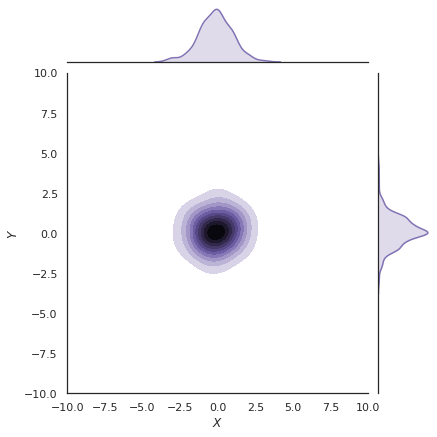

In [126]:
time=2
g = sns.jointplot(x=x_array[time],y=y_array[time], kind="kde", color="m",xlim=(-10,10),ylim=(-10,10), bw=0.75)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

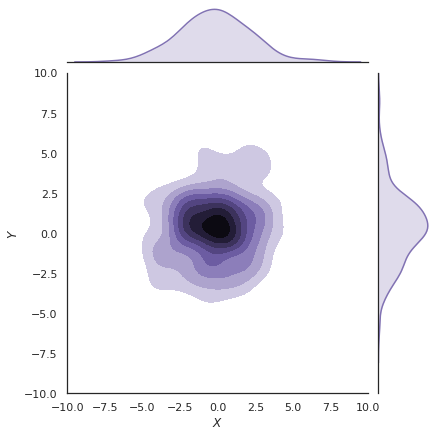

In [127]:
time=10
g = sns.jointplot(x=x_array[time],y=y_array[time], kind="kde", color="m",xlim=(-10,10),ylim=(-10,10), bw=0.75)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

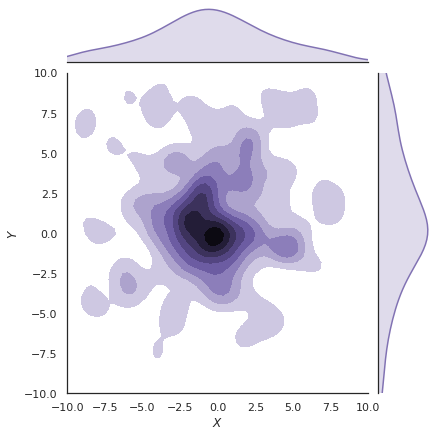

In [128]:
time=40
g = sns.jointplot(x=x_array[time],y=y_array[time], kind="kde", color="m",xlim=(-10,10),ylim=(-10,10), bw=0.75)
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("$X$", "$Y$");

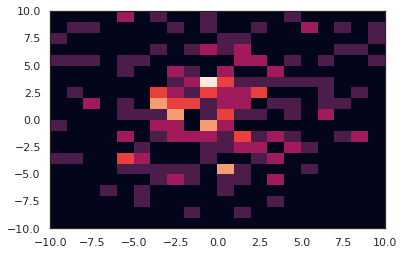

In [129]:
plt.hist2d(x=x_array[49],y=y_array[49],bins=20,range=[[-10,10],[-10,10]],density=True)
plt.show()

In [130]:
histo=np.histogram2d(x=x_array[0],y=y_array[0],bins=20,range=[[-10,10],[-10,10]])
U = np.empty(histo[0].shape).flatten()
x_m, y_m = np.meshgrid(histo[1].flatten()[:-1], histo[1].flatten()[:-1])
X_m= np.empty(x_m.shape).flatten()
Y_m= np.empty(y_m.shape).flatten()
T = np.empty(x_m.shape).flatten()

In [131]:
for t in range(1,len(x_array)):
    print(t)
    histo=np.histogram2d(x=x_array[t],y=y_array[t],bins=20,range=[[-10,10],[-10,10]])
    u = histo[0].flatten()
    x_m, y_m = np.meshgrid(shift(histo[1].flatten()), shift(histo[1].flatten()))
    t = t*np.ones_like(x_m).flatten()
    X_m = np.vstack([X_m,x_m.flatten()])
    Y_m = np.vstack([Y_m,y_m.flatten()])
    T = np.vstack([T,t])
    U = np.vstack([U,u])
X_m= X_m[1:]
Y_m= Y_m[1:]
T = T[1:]
U = U[1:]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


In [132]:
X = np.transpose((T.flatten(),X_m.flatten(), Y_m.flatten()))
y = U.reshape((U.size, 1))/10.0

print(X.shape, y.shape)

(20400, 3) (20400, 1)


# DeepMoD

In [158]:
from scipy.io import loadmat
data_1 =  loadmat('../data/processed/Diffusion_2D_D01.mat')
usol = np.real(data_1['Expression1'])
usol= usol.reshape((26,26,21,4))

x_1 = usol[:,:,0]
y_1 = usol[:,:,1]
t_1 = usol[:,:,2]
y_1 = usol[:,:,3]
X = np.transpose((t_1.flatten(),x_1.flatten(),y_1.flatten()))
#y= y_1.reshape((y_1.size, 1)).astype('float32')
y = y_1.flatten()
y = y.reshape(y.shape[0],1)

In [5]:
from scipy.io import loadmat
data_1 =  loadmat('../data/processed/Diffusion_2D_D01_big.mat')
usol = np.real(data_1['Expression1'])
usol= usol.reshape((101,101,6,4))

x_1 = usol[:,:,0]
y_1 = usol[:,:,1]
t_1 = usol[:,:,2]
y_1 = usol[:,:,3]
X = np.transpose((t_1.flatten(),x_1.flatten(),y_1.flatten()))
y= y_1.reshape((y_1.size, 1)).astype('float32')
#y = y_1.flatten()
#y = y.reshape(y.shape[0],1)

In [6]:
y.shape

(40804, 1)

In [7]:
number_of_samples = 2500

idx = np.random.permutation(y.size)
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [8]:
print(X_train.shape, y_train.shape)

torch.Size([2500, 3]) torch.Size([2500, 1])


In [9]:
print(X_train.shape, y_train.shape)

torch.Size([2500, 3]) torch.Size([2500, 1])


In [10]:
optim_config = {'lambda': 10**-5, 'max_iterations': 25001}

In [11]:
network_config = {'input_dim': 3, 'hidden_dim': 20, 'layers': 3, 'output_dim': y_train.shape[1]}

In [12]:
library_config = {'type': library_1D_in_group_c, 'poly_order': 1, 'diff_order': 2}
#library_config = {'type': library_2Din_1Dout, 'poly_order': 1, 'diff_order': 2}

In [13]:
network, coeff_vector_list, sparsity_mask_list = deepmod_init(network_config, library_config)

1


In [ ]:
time_deriv_list, theta, coeff_vector_list = train_group(X_train, y_train, network, coeff_vector_list, sparsity_mask_list, library_config, optim_config)

Epoch | Total loss | MSE | PI | L1 
0 1.3E+01 1.3E+01 1.0E-04 2.0E-05 2.0E-05
tensor([[-0.6862],
        [-0.1079],
        [-0.5752],
        [-1.0439],
        [-0.1910],
        [ 0.2982],
        [-0.7915],
        [ 2.5247]], requires_grad=True)
5000 1.2E-04 1.5E-05 4.2E-06 4.9E-05 4.9E-05
tensor([[-0.4374],
        [ 0.1683],
        [-0.6534],
        [-0.7239],
        [-0.1849],
        [ 0.3335],
        [-0.8337],
        [ 2.2669]], requires_grad=True)
10000 6.7E-05 8.9E-06 1.6E-06 2.8E-05 2.8E-05
tensor([[-0.2845],
        [ 0.3932],
        [-0.7288],
        [-0.5773],
        [-0.1526],
        [ 0.2923],
        [-0.5947],
        [ 1.9347]], requires_grad=True)
15000 1.2E-04 8.0E-05 2.9E-06 1.6E-05 1.6E-05
tensor([[-5.4627e-02],
        [ 5.2956e-01],
        [-6.9523e-01],
        [ 8.0631e-04],
        [-8.4669e-02],
        [ 2.3455e-01],
        [-4.8103e-01],
        [ 1.1122e+00]], requires_grad=True)


In [40]:
coeff_vector_list 

[tensor([[-2.6544e-02],
         [-2.4127e-02],
         [ 1.2121e-02],
         [ 5.1425e-05]], requires_grad=True)]

In [90]:
X_all = torch.tensor(X, dtype=torch.float32, requires_grad=True) 
prediction_full = network(X_all).cpu()

In [100]:
52*20*20

20800

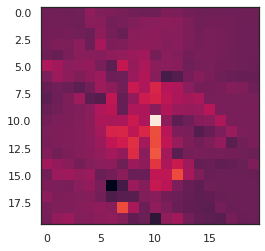

In [103]:
plt.imshow(prediction_full.detach().numpy().reshape(51,20,20)[50,:,:].T, aspect=1)

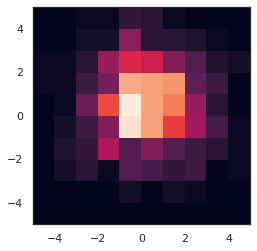

In [45]:
time = 5
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist2d(x=x_array[time],y=y_array[time],bins=10,range=[[-5,5],[-5,5]])
ax.set_aspect(aspect=1)
plt.show()

# Find the maximal values

In [283]:
U = np.empty(histo[0].shape).flatten()
for t in range(1,len(x_array)):
    print(t)
    histo=np.histogram2d(x=x_array[t],y=y_array[t],bins=20,range=[[-10,10],[-10,10]])
    u = histo[0].flatten()
    x_m, y_m = np.meshgrid(histo[1].flatten()[:-1], histo[1].flatten()[:-1])
    t = np.ones_like(x_m).flatten()
    U = np.vstack([U,u])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [161]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(x_m, y_v, u, cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('t = 0')

im1 = axes[1].contourf(x_v[:,:,10], y_v[:,:,10], u_v[:,:,10], cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('t = 10')

im2 = axes[2].contourf(x_v[:,:,20], y_v[:,:,20], u_v[:,:,20], cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('t= 20')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

In [162]:
x_m.shape

(41, 1600)

In [132]:
for i in range(0,len(x_array)):
    histo=np.histogram2d(x=x_array[i],y=y_array[i],bins=40)[0]
    position_max=np.where(histo == np.amax(histo))
    if len(position_max[0]) ==1:
        print(np.squeeze(position_max))
    else:
        print(np.squeeze(position_max[0]))

[20 20]
[20 16]
[20 20]
[17 22]
[20 20]
[17 22]
[16 20]
[21 16]
[21 17]
[24 18]
[23 20]
[22 22]
[21 21]
[18 21]
[21 18]
[21 18]
[15 20]
[14 21]
[14 16]
[16 21]
[14 21]


In [113]:
histo=np.histogram2d(x=x_array[5],y=y_array[5],bins=20)[0]
position_max=np.where(histo == np.amax(histo))
print(position_max)

(array([ 8, 11]), array([11, 11]))


In [114]:
np.amax(histo)

20.0

In [117]:
len(np.where(histo == np.amax(histo)))

2